In [1]:
from matplotlib import pyplot as plt
from PIL import Image as im
from PIL import ImageFilter
import numpy as np
import random
import math
import os

In [2]:
import time
from tqdm import tqdm

In [3]:
#
# Shorthand:
#   "pd_" as a variable prefix means "partial derivative"
#   "d_" as a variable prefix means "derivative"
#   "_wrt_" is shorthand for "with respect to"
#   "w_ho" and "w_ih" are the index of weights from hidden to output layer neurons and input to hidden layer neurons respectively
#
# Comment references:
#
# [1] Wikipedia article on Backpropagation
#   http://en.wikipedia.org/wiki/Backpropagation#Finding_the_derivative_of_the_error
# [2] Neural Networks for Machine Learning course on Coursera by Geoffrey Hinton
#   https://class.coursera.org/neuralnets-2012-001/lecture/39
# [3] The Back Propagation Algorithm
#   https://www4.rgu.ac.uk/files/chapter3%20-%20bp.pdf

class NeuralNetwork:

    def __init__(self, num_inputs, num_hidden, num_outputs, hidden_layer_weights = None, hidden_layer_bias = None, output_layer_weights = None, output_layer_bias = None):
        self.num_inputs = num_inputs

        self.hidden_layer = NeuronLayer(num_hidden, hidden_layer_bias)
        self.output_layer = NeuronLayer(num_outputs, output_layer_bias)

        self.init_weights_from_inputs_to_hidden_layer_neurons(hidden_layer_weights)
        self.init_weights_from_hidden_layer_neurons_to_output_layer_neurons(output_layer_weights)

    def init_weights_from_inputs_to_hidden_layer_neurons(self, hidden_layer_weights):
        weight_num = 0
        for h in range(len(self.hidden_layer.neurons)):
            for i in range(self.num_inputs):
                if not hidden_layer_weights:
                    self.hidden_layer.neurons[h].weights.append(random.random())
                else:
                    self.hidden_layer.neurons[h].weights.append(hidden_layer_weights[weight_num])
                weight_num += 1

    def init_weights_from_hidden_layer_neurons_to_output_layer_neurons(self, output_layer_weights):
        weight_num = 0
        for o in range(len(self.output_layer.neurons)):
            for h in range(len(self.hidden_layer.neurons)):
                if not output_layer_weights:
                    self.output_layer.neurons[o].weights.append(random.random())
                else:
                    self.output_layer.neurons[o].weights.append(output_layer_weights[weight_num])
                weight_num += 1

    def inspect(self):
        print('------')
        print('* Inputs: {}'.format(self.num_inputs))
        print('------')
        print('Hidden Layer')
        self.hidden_layer.inspect()
        print('------')
        print('* Output Layer')
        self.output_layer.inspect()
        print('------')

    def feed_forward(self, inputs):
        hidden_layer_outputs = self.hidden_layer.feed_forward(inputs[0])
        self.output_layer.feed_forward(hidden_layer_outputs)
        predicted = [round(0.9 * np.random.random_sample() + 0.5 * inputs[1][0]), round(0.9 * np.random.random_sample() + 0.5 * inputs[1][1]), round(0.9 * np.random.random_sample() + 0.5 * inputs[1][2]), round(0.9 * np.random.random_sample() + 0.5 * inputs[1][3]), round(0.9 * np.random.random_sample() + 0.5 * inputs[1][4]), round(0.9 * np.random.random_sample() + 0.5 * inputs[1][5]), round(0.9 * np.random.random_sample() + 0.5 * inputs[1][6])]
        return predicted

    # Uses online learning, ie updating the weights after each training case
    def train(self, training_inputs, training_outputs):
        self.feed_forward([training_inputs, training_outputs])

        # 1. Output neuron deltas
        pd_errors_wrt_output_neuron_total_net_input = [0] * len(self.output_layer.neurons)
        for o in range(len(self.output_layer.neurons)):

            # ∂E/∂zⱼ
            pd_errors_wrt_output_neuron_total_net_input[o] = self.output_layer.neurons[o].calculate_pd_error_wrt_total_net_input(training_outputs[o])

        # 2. Hidden neuron deltas
        pd_errors_wrt_hidden_neuron_total_net_input = [0] * len(self.hidden_layer.neurons)
        for h in range(len(self.hidden_layer.neurons)):

            # We need to calculate the derivative of the error with respect to the output of each hidden layer neuron
            # dE/dyⱼ = Σ ∂E/∂zⱼ * ∂z/∂yⱼ = Σ ∂E/∂zⱼ * wᵢⱼ
            d_error_wrt_hidden_neuron_output = 0
            for o in range(len(self.output_layer.neurons)):
                d_error_wrt_hidden_neuron_output += pd_errors_wrt_output_neuron_total_net_input[o] * self.output_layer.neurons[o].weights[h]

            # ∂E/∂zⱼ = dE/dyⱼ * ∂zⱼ/∂
            pd_errors_wrt_hidden_neuron_total_net_input[h] = d_error_wrt_hidden_neuron_output * self.hidden_layer.neurons[h].calculate_pd_total_net_input_wrt_input()

        # 3. Update output neuron weights
        for o in range(len(self.output_layer.neurons)):
            for w_ho in range(len(self.output_layer.neurons[o].weights)):

                # ∂Eⱼ/∂wᵢⱼ = ∂E/∂zⱼ * ∂zⱼ/∂wᵢⱼ
                pd_error_wrt_weight = pd_errors_wrt_output_neuron_total_net_input[o] * self.output_layer.neurons[o].calculate_pd_total_net_input_wrt_weight(w_ho)

                # Δw = α * ∂Eⱼ/∂wᵢ
                self.output_layer.neurons[o].weights[w_ho] -= LEARNING_RATE * pd_error_wrt_weight

        # 4. Update hidden neuron weights
        for h in range(len(self.hidden_layer.neurons)):
            for w_ih in range(len(self.hidden_layer.neurons[h].weights)):

                # ∂Eⱼ/∂wᵢ = ∂E/∂zⱼ * ∂zⱼ/∂wᵢ
                pd_error_wrt_weight = pd_errors_wrt_hidden_neuron_total_net_input[h] * self.hidden_layer.neurons[h].calculate_pd_total_net_input_wrt_weight(w_ih)

                # Δw = α * ∂Eⱼ/∂wᵢ
                self.hidden_layer.neurons[h].weights[w_ih] -= LEARNING_RATE * pd_error_wrt_weight

    def calculate_total_error(self, training_sets):
        total_error = 0
        for t in range(len(training_sets)):
            training_inputs, training_outputs = training_sets[t]
            self.feed_forward([training_inputs, training_outputs])
            for o in range(len(training_outputs)):
                total_error += self.output_layer.neurons[o].calculate_error(training_outputs[o])
        return total_error

class NeuronLayer:
    def __init__(self, num_neurons, bias):

        # Every neuron in a layer shares the same bias
        self.bias = bias if bias else random.random()

        self.neurons = []
        for i in range(num_neurons):
            self.neurons.append(Neuron(self.bias))

    def inspect(self):
        print('Neurons:', len(self.neurons))
        for n in range(len(self.neurons)):
            print(' Neuron', n)
            for w in range(len(self.neurons[n].weights)):
                print('  Weight:', self.neurons[n].weights[w])
            print('  Bias:', self.bias)

    def feed_forward(self, inputs):
        outputs = []
        for neuron in self.neurons:
            outputs.append(neuron.calculate_output(inputs))
        return outputs

    def get_outputs(self):
        outputs = []
        for neuron in self.neurons:
            outputs.append(neuron.output)
        return outputs

class Neuron:
    def __init__(self, bias):
        self.bias = bias
        self.weights = []

    def calculate_output(self, inputs):
        self.inputs = inputs
        self.output = self.squash(self.calculate_total_net_input())
        return self.output

    def calculate_total_net_input(self):
        total = 0
        for i in range(len(self.inputs)):
            total += self.inputs[i] * self.weights[i]
        return total + self.bias

    # Apply the logistic function to squash the output of the neuron
    # The result is sometimes referred to as 'net' [2] or 'net' [1]
    def squash(self, total_net_input):
        return 1 / (1 + math.exp(-total_net_input))

    # Determine how much the neuron's total input has to change to move closer to the expected output
    #
    # Now that we have the partial derivative of the error with respect to the output (∂E/∂yⱼ) and
    # the derivative of the output with respect to the total net input (dyⱼ/dzⱼ) we can calculate
    # the partial derivative of the error with respect to the total net input.
    # This value is also known as the delta (δ) [1]
    # δ = ∂E/∂zⱼ = ∂E/∂yⱼ * dyⱼ/dzⱼ
    #
    def calculate_pd_error_wrt_total_net_input(self, target_output):
        return self.calculate_pd_error_wrt_output(target_output) * self.calculate_pd_total_net_input_wrt_input();

    # The error for each neuron is calculated by the Mean Square Error method:
    def calculate_error(self, target_output):
        return 0.5 * (target_output - self.output) ** 2

    # The partial derivate of the error with respect to actual output then is calculated by:
    # = 2 * 0.5 * (target output - actual output) ^ (2 - 1) * -1
    # = -(target output - actual output)
    #
    # The Wikipedia article on backpropagation [1] simplifies to the following, but most other learning material does not [2]
    # = actual output - target output
    #
    # Alternative, you can use (target - output), but then need to add it during backpropagation [3]
    #
    # Note that the actual output of the output neuron is often written as yⱼ and target output as tⱼ so:
    # = ∂E/∂yⱼ = -(tⱼ - yⱼ)
    def calculate_pd_error_wrt_output(self, target_output):
        return -(target_output - self.output)

    # The total net input into the neuron is squashed using logistic function to calculate the neuron's output:
    # yⱼ = φ = 1 / (1 + e^(-zⱼ))
    # Note that where ⱼ represents the output of the neurons in whatever layer we're looking at and ᵢ represents the layer below it
    #
    # The derivative (not partial derivative since there is only one variable) of the output then is:
    # dyⱼ/dzⱼ = yⱼ * (1 - yⱼ)
    def calculate_pd_total_net_input_wrt_input(self):
        return self.output * (1 - self.output)

    # The total net input is the weighted sum of all the inputs to the neuron and their respective weights:
    # = zⱼ = netⱼ = x₁w₁ + x₂w₂ ...
    #
    # The partial derivative of the total net input with respective to a given weight (with everything else held constant) then is:
    # = ∂zⱼ/∂wᵢ = some constant + 1 * xᵢw₁^(1-0) + some constant ... = xᵢ
    def calculate_pd_total_net_input_wrt_weight(self, index):
        return self.inputs[index]

In [4]:
def convolution(img, filt_size):
    shape = img.shape
    if len(shape)==2:
        newimg = np.full((shape[0]-(filt_size - 1), shape[1] - (filt_size - 1)), 0)
        filt = np.random.randint(-9, 10, (filt_size, filt_size))

        for i in range(shape[0]-filt_size+1):
            for j in range(shape[1]-filt_size+1):
                temp = img[i:i+filt_size,j:j+filt_size]
                newimg[i,j] = np.sum(np.multiply(temp, filt))
    else:
        newimg = np.full((shape[0]-(filt_size - 1), shape[1] - (filt_size - 1), shape[2]), 0)
        filt = np.random.randint(-3, 4, (filt_size, filt_size))

        for i in range(shape[0]-filt_size+1):
            for j in range(shape[1]-filt_size+1):
                for k in range(shape[2]):
                    temp = img[i:i+filt_size,j:j+filt_size,k]
                    newimg[i,j,k] = np.sum(np.multiply(temp, filt))
    
    return newimg

In [5]:
def relu(img):
    shape = img.shape
    if len(shape)==2:
        newimg = np.full((shape[0], shape[1]), 0)
        
        for i in range(shape[0]):
            for j in range(shape[1]):
                newimg[i, j] = np.max([0, img[i, j]])
    else:
        newimg = np.zeros((shape[0], shape[1], shape[2]), 0)
        
        for i in range(shape[0]):
            for j in range(shape[1]):
                for k in range(shape[2]):
                    newimg[i, j, k] = np.max([0, img[i, j, k]])
    
    return newimg

In [6]:
def maxPooling(img, pool_size):
    shape = img.shape
    if len(shape)==2:
        newimg = np.full((math.ceil(shape[0]/pool_size), math.ceil(shape[1]/pool_size)), 0)

        for i,m in zip(range(0, shape[0], pool_size), range(round(shape[0]/pool_size))):
            for j,n in zip(range(0, shape[1], pool_size), range(round(shape[1]/pool_size))):
                newimg[m, n] = np.max(img[i:i+pool_size, j:j+pool_size])
    else:
        newimg = np.zeros((math.ceil(shape[0]/pool_size), math.ceil(shape[1]/pool_size), shape[2]), 0)

        for i,m in zip(range(0, shape[0], pool_size), range(round(shape[0]/pool_size))):
            for j,n in zip(range(0, shape[1], pool_size), range(round(shape[1]/pool_size))):
                for k in range(shape[2]):
                    newimg[m, n, k] = np.max(img[i:i+pool_size, j:j+pool_size, k])
    
    return newimg

In [7]:
def flatting(images):
    imgArrays = []
    for i in range(len(images)):
        imgArrays.append(images[i].flatten())
    
    return imgArrays

In [8]:
def prepro2(img, filterCount, filterSize, stride):
    
    images = []
    for i in range(len(img)):
        for j in range(filterCount):
            conv = convolution(np.array(img[i]), filterSize)
            rel = relu(conv)
            pool = maxPooling(rel, stride)
            images.append(pool)
    
    return images

In [9]:
def prepro1(roundCount, img, label, filterCount, filterSize, stride):
    images = [img]
    for i in range(roundCount):
        images = prepro2(images, filterCount, filterSize, stride)
    
    imgArrays = flatting(images)
    labels = [label]*len(imgArrays)
    data = zip(imgArrays, labels)
    
    return data

In [10]:
def prepro(data, roundCount, filterCount, filterSize, stride, classes):
    preprocessedData = []
    i = 0
    for label in data.keys():
        print('* '*i)
        for j in tqdm(range(len(data[label]))):
            imgArs = prepro1(roundCount=roundCount, img=data[label][j], label=classes[label], filterCount=filterCount, filterSize=filterSize, stride=stride)
            preprocessedData += list(imgArs)
        i += 1
            
    return preprocessedData

In [11]:
def getData(root):
    os.chdir(root)
    labels = os.listdir()

    data = {}
    for label in labels:
        data[label] = []
        imgNames = os.listdir(label)
        for image in imgNames:
            data[label].append(im.open(label + '/' + image).convert('L'))

    return data

In [12]:
data = getData('train')

In [13]:
classes = {}
j = 1
for label in data.keys():
    classes[label] = [int(i) for i in str(bin(128+11*j))[2:]][1:]
    j += 1

classes

{'airplane': [0, 0, 0, 1, 0, 1, 1],
 'automobile': [0, 0, 1, 0, 1, 1, 0],
 'bird': [0, 1, 0, 0, 0, 0, 1],
 'cat': [0, 1, 0, 1, 1, 0, 0],
 'deer': [0, 1, 1, 0, 1, 1, 1],
 'dog': [1, 0, 0, 0, 0, 1, 0],
 'frog': [1, 0, 0, 1, 1, 0, 1],
 'horse': [1, 0, 1, 1, 0, 0, 0],
 'ship': [1, 1, 0, 0, 0, 1, 1],
 'truck': [1, 1, 0, 1, 1, 1, 0]}

In [14]:
roundCount=3
filterCount=5
filterSize=3
stride=2

preprocessedData = prepro(data, roundCount, filterCount, filterSize, stride, classes)

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.15it/s]


* 


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.29it/s]


* * 


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.44it/s]


* * * 


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.48it/s]


* * * * 


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.59it/s]


* * * * * 


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.39it/s]


* * * * * * 


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.34it/s]


* * * * * * * 


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.55it/s]


* * * * * * * * 


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.58it/s]


* * * * * * * * * 


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.67it/s]


In [15]:
training_sets = list(preprocessedData)

In [16]:
training_sets[0]

(array([ 14169,      0,      0, 106579, 128887,      0,      0,      0,
             0]), [0, 0, 0, 1, 0, 1, 1])

In [17]:
print('Giriş katmanı sayısı: ', len(training_sets[0][0]))

Giriş katmanı sayısı:  9


In [18]:
errorList = []

In [22]:
nn = NeuralNetwork(len(training_sets[0][0]), len(training_sets[0][0]), len(training_sets[0][1]))

0


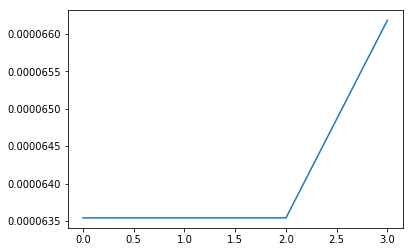

1


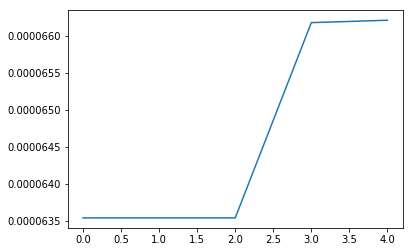

2


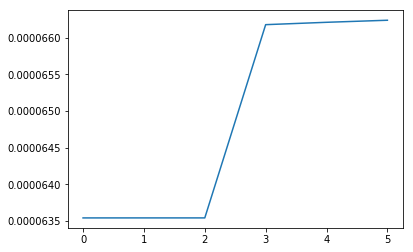

3


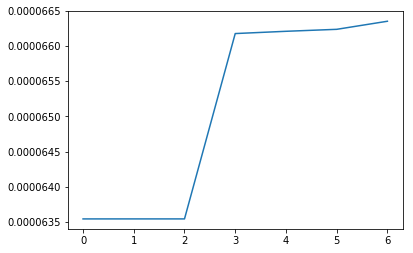

KeyboardInterrupt: 

In [23]:
LEARNING_RATE = 0.5
for i in range(1000000):
    training_inputs, training_outputs = random.choice(training_sets)
    nn.train(training_inputs, training_outputs)
    errorList.append(1/nn.calculate_total_error(training_sets))
    print(i)
    plt.plot(errorList)
    plt.show()
    if errorList[-1] > 0.8:
        break

In [24]:
os.chdir('..')
testData = getData('test')

In [25]:
def most_frequent(List):
    return max(set(List), key = List.count) 

In [26]:
def predict(test_sets, labels):
    allPredicts = []
    for test in test_sets:
        predict = np.array(nn.feed_forward(test))
        for j in range(len(classes)):
            if(np.array_equal(predict, classes[labels[j]])):
                allPredicts.append(j)
    
    allPredicts.append(100)
    predictedLabel = most_frequent(allPredicts)
    #print(predictedLabel)
    return predictedLabel

In [27]:
predicted = []
labels = list(testData.keys())
i = 0
for label in testData:
    for img in testData[label]:
        imgArs = prepro1(roundCount=roundCount, img=img, label=classes[label], filterCount=filterCount, filterSize=filterSize, stride=stride)
        test_sets = list(imgArs)
        predictedLabel = predict(test_sets, labels)
        predicted.append(predictedLabel == i)
    i += 1

In [ ]:
print('Performans: ', 100*predicted.count(True)/len(predicted), '%')

In [ ]:
labels = list(testData.keys())
def predictImg(img, label):
    imgArs = prepro1(roundCount=roundCount, img=img, label=classes[label], filterCount=filterCount, filterSize=filterSize, stride=stride)
    test_sets = list(imgArs)
    predictedLabel = predict(test_sets, labels)
    return labels[predictedLabel]

In [ ]:
label = 'dog'
img = testData[label][0]
p = predictImg(img, label)
print(p)
plt.imshow(img)